In [1]:
import xarray as xr
import grib2io
import pandas as pd
import datetime
from glob import glob
from tqdm.auto import tqdm
import numpy as np
import multiprocessing
from numba import jit
import scipy
from netCDF4 import Dataset


import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib
from mpl_toolkits.basemap import Basemap
matplotlib.rcParams.update({
 "savefig.facecolor": "w",
 "figure.facecolor" : 'w',
 "figure.figsize" : (8,6),
 "text.color": "k",
 "legend.fontsize" : 20,
 "font.size" : 30,
 "axes.edgecolor": "k",
 "axes.labelcolor": "k",
 "axes.linewidth": 3,
 "xtick.color": "k",
 "ytick.color": "k",
 "xtick.labelsize" : 25,
 "ytick.labelsize" : 25,
 "ytick.major.size" : 12,
 "xtick.major.size" : 12,
 "ytick.major.width" : 2,
 "xtick.major.width" : 2,
 "font.family": 'STIXGeneral',
 "mathtext.fontset" : "cm"})

## utils

In [12]:
def open_and_sum(files, ny, nx):
    #open each chunk of mswep files to get 24 precip totals for some number of days
    apcp_sums = np.zeros((ny,nx),dtype=np.float32)
    
    #sum to get 24 hour totals --> 8 files in a day
    for hour in range(8):
        f = files[hour]
        ds = Dataset(f, mode='r')
        apcp_var = ds.variables['precipitation']
        apcp = np.asarray(apcp_var[0])
        ds.close()
        apcp_sums += apcp
    return apcp_sums

In [7]:
from nimbl import stations  #.from_mos2ktbl

#selected stations for analysis
station_data = '//scratch1/NCEPDEV/mdl/Eric.Engle/gitrepos/blend/fix/common/mdl_station.tbl'
station_points = stations.from_mos2ktbl(station_data, ['KSEA','KMSP','KBOS', 'KLAS','KLIT','KMCO', 'KDEN', 'KCVG'])

#rename weird ones
st_names = station_points['name'].copy()
st_names[3] = 'Las Vegas'
st_names[6] = 'Denver'
st_names[8] = 'Cincinnati'

In [8]:
def get_nearest_grid(lat_input, long_input):
    # Get indices of the nearest lat/lon values
    # Lat/long input will be values corresponding to chosen stations
    lat_index, lon_index = [],[]


    for i in range(len(lat_input)):
        a = np.abs(lat_arr-station_lats[i]) + np.abs(lon_arr-station_lons[i])
        i,j = np.unravel_index(a.argmin(), a.shape)
        lat_index.append(i)
        lon_index.append(j)
    return lat_index, lon_index

def to360(x):
    return (x - 180) % 360 + 180

station_lats = station_points['lat']
station_lons = to360(station_points['lon']) #need to convert from E/W to 0-360

lat_idx, lon_idx = get_nearest_grid(station_lats, station_lons)

conus_gp = (lat_idx, lon_idx)

# plot locations

In [98]:
month = 4

ds = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/limit_water_v4/blend.supplemental_locations_{month}.co.2p5.nc',
             mode="r")

In [104]:
#unpack lats and lons to index over
lat_arr = ds.latitude.data
lon_arr = ds.longitude.data

xlocs = ds.xlocations.data
ylocs = ds.ylocations.data

In [106]:
#load MSWEP precip data just to plot over
dt = datetime.datetime(year=2023, month=month, day=1)
this_doy = int(dt.strftime('%j'))

precip = xr.open_mfdataset(sorted(glob(f'/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2023/2023{this_doy:03d}.*.nc')), 
                           combine="nested", engine='h5netcdf',concat_dim='time', parallel=False)

In [107]:
precip_totals = precip.precipitation.sum(dim='time').data.compute()

In [108]:
precip_totals = np.where(precip_totals <= 0.254, precip_totals*0., precip_totals)

/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 17.86 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Text(0.5, 1.0, 'Supplemental Locations April 2023')

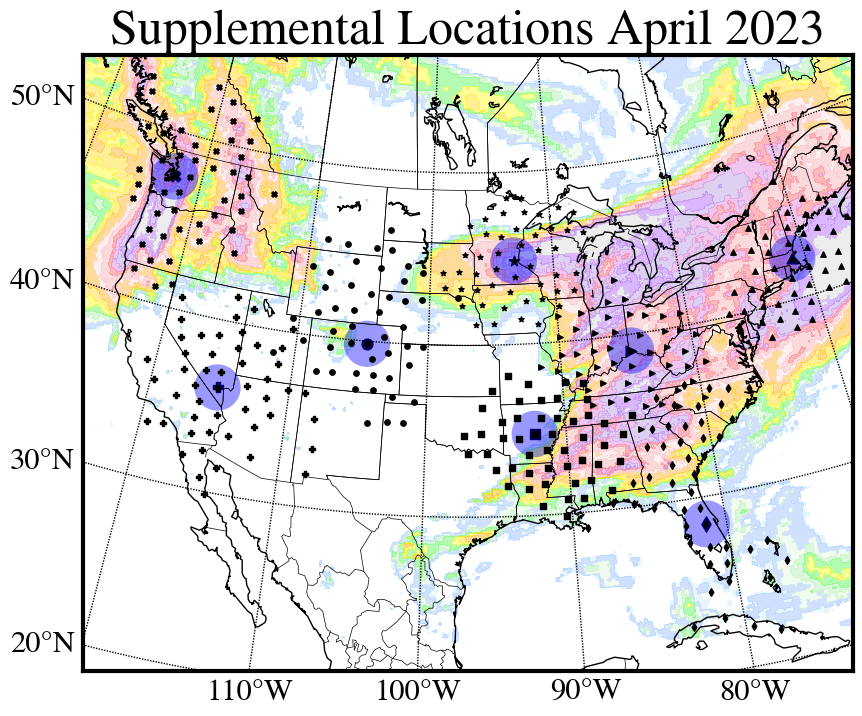

In [111]:
fig, axes = plt.subplots(1,1, figsize=(16,8))

clevs_precip = np.array([0.0,0.1,0.3,0.5,0.7,1.0,1.5,2.0,3.0,5.0,7.0,10.0,12.0,15.0,20.,25.])

colorst = ['White','#E4FFFF','#C4E8FF','#8FB3FF','#D8F9D8',\
    '#A6ECA6','#42F742','Yellow','Gold','Orange','#FCD5D9','#F6A3AE',\
        '#FA5257','Orchid','#AD8ADB','#A449FF','LightGray'] 

lats, lons = precip.latitude.data, precip.longitude.data
m = Basemap(projection='lcc',lon_0=-97,lat_0=39,width=5e6,height=4e6, resolution='l')
xx, yy = m(lons,lats) #note to self, x=lons y=lats

cs = m.contourf(xx,yy,precip_totals,extend='both',ax=axes,levels= clevs_precip,cmap=None, alpha=0.4,colors=colorst)
#cbar=plt.colorbar(cs,orientation='horizontal')
#cbar.set_label(f'Precip Totals {dt.strftime("%Y-%m-%d")} [mm]')

def radius_for_tissot(dist_km): 
    return np.rad2deg(dist_km/6367.) 


#supp locations
markers=['X', '*', '^', 'P', 's', 'd', 'o', 'o', '>']
for loc in range(len(station_lats)):
    if loc == 7:
        continue
    #plot orgin points
    x, y = m(station_lons[loc], station_lats[loc])  # transform coordinates
    plt.scatter(x, y, s=60, marker=markers[loc], color='black')

    #plot radius where water points are allowed
    lon0, lat0 = station_lons[loc], station_lats[loc]
    m.tissot(lon0, lat0, radius_for_tissot(150), 256, facecolor='b', alpha=0.4)

    #plot SLs
    x_thisloc = xlocs[:,lat_idx[loc], lon_idx[loc]]
    y_thisloc = ylocs[:,lat_idx[loc], lon_idx[loc]]
    #bookkeeping for fortran --> python indices
    x_thisloc = [int(i)-1 for i in x_thisloc]
    y_thisloc = [int(i)-1 for i in y_thisloc]
    #index lat/lon
    sl_lons = lon_arr[y_thisloc, x_thisloc]
    sl_lats = lat_arr[y_thisloc, x_thisloc]
    x, y = m(sl_lons, sl_lats)  # transform coordinates
    plt.scatter(x, y, s=15, marker=markers[loc], color='black')


m.drawcoastlines(ax=axes)
m.drawcountries(ax=axes)
m.drawstates(ax=axes)
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes)
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes)

plt.title(f'Supplemental Locations {dt.strftime("%B")} 2023')

# How well correlated are the supplemental locations to the origin point?

Compare precipitation distributions between origin points and their supplemental locations. Precipitation data from 24 hour precip accumulation from MSWEP 3 hourly data.

In [37]:
month = 4

ds = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/limit_water_v4/blend.supplemental_locations_{month}.co.2p5.nc',
             mode="r")
ds

<xarray.Dataset>
Dimensions:        (ya: 1597, xa: 2345, xsupp: 50)
Coordinates:
    latitude       (ya, xa) float32 ...
    longitude      (ya, xa) float32 ...
Dimensions without coordinates: ya, xa, xsupp
Data variables:
    xlocations     (xsupp, ya, xa) float64 ...
    ylocations     (xsupp, ya, xa) float64 ...
    nsupplemental  (ya, xa) float32 ...
    differences    (xsupp, ya, xa) float32 ...
Attributes:
    domain:   co
    month:    4

In [38]:
#lat,lon indices for SL locations
xlocs = ds.xlocations.data
ylocs = ds.ylocations.data

#unpack lats and lons to index over
lat_arr = ds.latitude.data
lon_arr = ds.longitude.data

In [39]:
#gather precip data for given month
precip_files=[]
for year in range(2002, 2024):
    t1 = datetime.datetime(year=year, month=month, day=1)
    try:
        t2 = datetime.datetime(year=year, month=month, day=31)
    except:
        t2 = datetime.datetime(year=year, month=month, day=30)
    first_doy = t1.strftime('%j')
    last_doy = t2.strftime('%j')
    for day in range(int(first_doy), int(last_doy)+1):
        precip_files.append(sorted(glob(f'/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/{year}/{year}{day:03d}.*.nc')))


In [40]:
nx = np.shape(ds.latitude)[1]
ny = np.shape(ds.latitude)[0]

n_processes = 24

print('Processing files, making daily sums')
start = datetime.datetime.now()
print(f'    Using {n_processes} CPUs')
with multiprocessing.Pool(n_processes) as P:
    out = P.starmap(open_and_sum, zip(precip_files, np.repeat(ny, len(precip_files)), np.repeat(nx, len(precip_files))))
out = np.asarray(out)
end=datetime.datetime.now()
print(f'    Finished in {(end-start).total_seconds()}s')
P.close()

Processing files, making daily sums
    Using 24 CPUs
    Finished in 39.681806s


## Differences: similarity to the origin point

In [41]:
diffs = ds.differences.data
diffs_at_locs = diffs[:,conus_gp[0], conus_gp[1]]
np.shape(diffs), np.shape(diffs_at_locs)

((50, 1597, 2345), (50, 9))

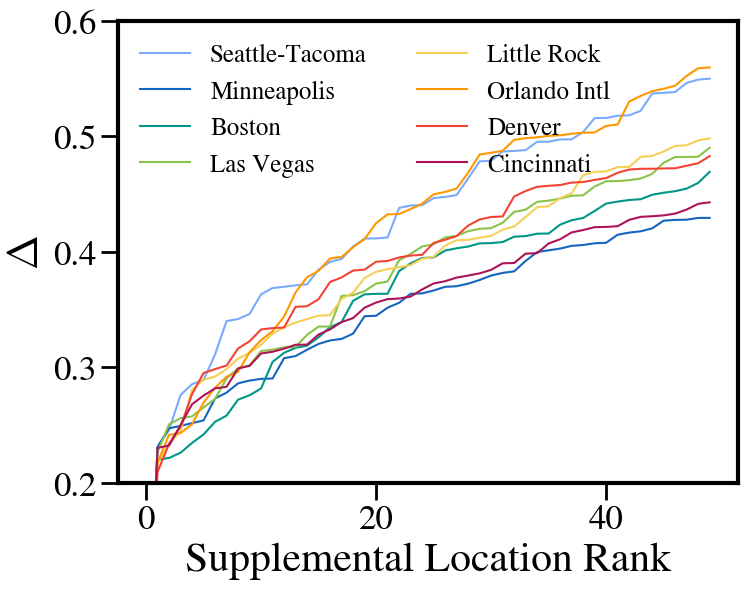

In [42]:
colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 'gray',
'#ad1457ff']

for i in range(len(st_names)):
    if i == 7:
        #skip duplicated Denver station
        continue
    plt.plot(np.arange(50), diffs_at_locs[:,i], color=colors[i],label=st_names[i].title())

plt.ylabel(f'$\Delta$')
plt.xlabel('Supplemental Location Rank')

plt.ylim([0.2,0.6])
plt.legend(frameon=False, fontsize=18,ncol=2)

## KS test --> pvalues

In [63]:
pvals=np.zeros((len(station_points['name']), 50))
for loc in range(len(station_points['name'])):
    this_loc = (conus_gp[0][loc], conus_gp[1][loc])
    x_thisloc = xlocs[:,this_loc[0], this_loc[1]]
    y_thisloc = ylocs[:,this_loc[0], this_loc[1]]
    gp_data = np.ravel(out[:,this_loc[0], this_loc[1]])
    for sl in range(50):
        sl_data = np.ravel(out[:, int(y_thisloc[sl])-1, int(x_thisloc[sl])-1])
        ks_test = scipy.stats.kstest(gp_data, sl_data)
        pvals[loc, sl] = ks_test.pvalue

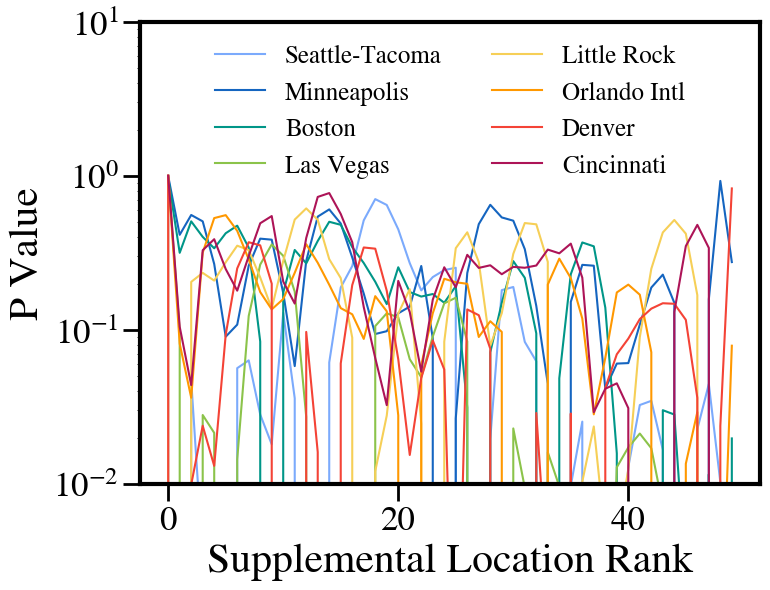

In [65]:
colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 'gray',
'#ad1457ff']

for loc in range(len(station_points['name'])):
    if loc == 7:
        continue
    sg = scipy.signal.savgol_filter(pvals[loc], window_length=20, polyorder=10)
    plt.semilogy(np.arange(len(sg)), sg, color=colors[loc],label=st_names[loc].title())

plt.ylim([1e-2, 1e1])

plt.ylabel('P Value')
plt.xlabel('Supplemental Location Rank')
plt.legend(frameon=False, fontsize=18, ncol=2)

## QQ plot

In [79]:
import statsmodels.api as sm

In [80]:
station_points

,call,link1,name,state,elev,lat,lon,tz,comment
0,KSEA,SEA,SEATTLE-TACOMA,WA,450,47.4500,-122.3000,-8,COMMISSIONED 10/01/96 NWRFC ...
1,KMSP,MSP,MINNEAPOLIS,MN,838,44.8833,-93.2167,-6,COMMISSIONED 06/01/96 MBRFC ...
2,KBOS,BOS,BOSTON,MA,29,42.3667,-71.0333,-5,COMMISSIONED ASOS 4/1/96 ...
3,KLAS,LAS,LAS VEGAS ASOS,NV,2180,36.0833,-115.1667,-8,COMMISSIONED 9/1/95 CNRFC/CBRFC RPT TIME-...
4,KLIT,LIT,LITTLE ROCK,AR,257,34.7333,-92.2333,-6,...
5,KMCO,MCO,ORLANDO INTL,FL,105,28.4333,-81.3167,-5,COMMISSIONED 07/01/96 ...
6,KDEN,DEN,DENVER INTL ASOS,CO,5431,39.8466,-104.6562,-7,DVX 2/94 CHNGD TO DEN 2/28/95 1ST SAO 8Z NMC ...
7,KDEN,DEN,DENVER STAPLETON,CO,5332,39.7500,-104.8667,-7,CALL LETTERS REUSED LAST SAO 2/28/95 AT 07Z ...
8,KCVG,CVG,COVINGTON ASOS,KY,877,39.0500,-84.6667,-5,COMMISSIONED 10/1/95 ...


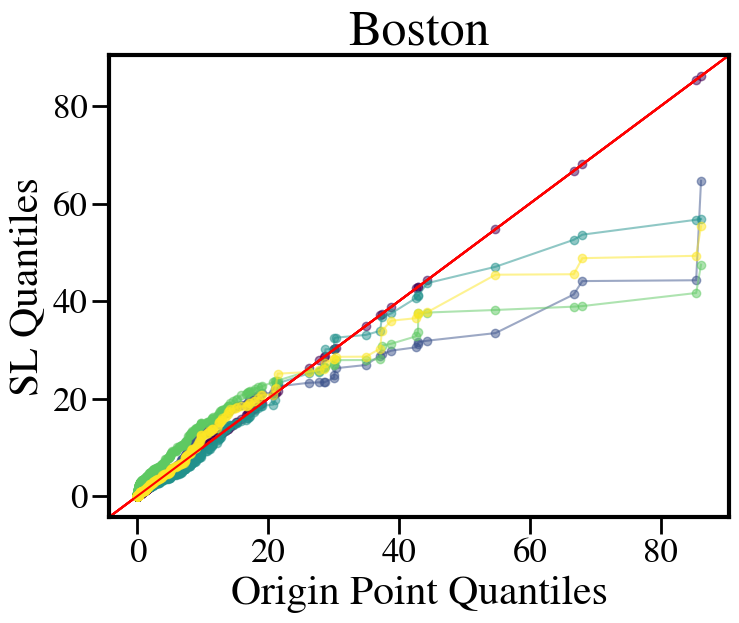

In [90]:
fig, ax = plt.subplots()

for loc in [2]:
    #origin point
    gp_data = np.ravel(out[:,conus_gp[0][loc], conus_gp[1][loc]])
    #for sl in range(10
    pp_gp = sm.ProbPlot(gp_data,dist='gamma')

    for sl in range(0,50,10):
    
        x_thisloc = xlocs[sl,conus_gp[0][loc], conus_gp[1][loc]]
        y_thisloc = ylocs[sl,conus_gp[0][loc], conus_gp[1][loc]]
        #bookkeeping for fortran --> python indices
        sl_data = np.ravel(out[:, int(y_thisloc)-1, int(x_thisloc)-1])

        pp_sl = sm.ProbPlot(sl_data,dist='gamma')
        color=cm.viridis(sl/40)
        pp_sl.qqplot(other=pp_gp, line='45', alpha=0.5,linestyle='-',markerfacecolor=color, markeredgecolor=color,color=color,ax=ax)
        plt.ylabel('SL Quantiles')
        plt.xlabel('Origin Point Quantiles')
        plt.title(station_points['name'][loc].title())
    

## Pearson Correlation and Covariance

In [27]:
p_coeff = np.zeros((len(station_points['name']), 50))
rand_coeff=[]
for loc in range(len(station_points['name'])):
    #origin point
    gp_data = np.ravel(out[:,conus_gp[0][loc], conus_gp[1][loc]])
    #p_coeff, rand_coeff = [], []

    #actual supplemental locations
    for sl in range(0,50):
        x_thisloc = xlocs[sl,conus_gp[0][loc], conus_gp[1][loc]]-1
        y_thisloc = ylocs[sl,conus_gp[0][loc], conus_gp[1][loc]]-1
        sl_data = np.ravel(out[:, int(y_thisloc), int(x_thisloc)])
        p_coeff[loc][sl] = np.corrcoef(gp_data, sl_data)[0][1]

    #50 random points
    #latidx_rand = np.random.randint(0,np.shape(lat_arr)[0], size=50)
    #lonidx_rand = np.random.randint(0,np.shape(lat_arr)[1], size=50)
    #for i in range(50):
    #    rand_data = np.ravel(out[:, int(latidx_rand[i]), int(lonidx_rand[i])])
    #    rand_coeff.append(np.corrcoef(gp_data, rand_data)[0][1])
    

Text(0, 0.5, 'Pearson Correlation Coeff')

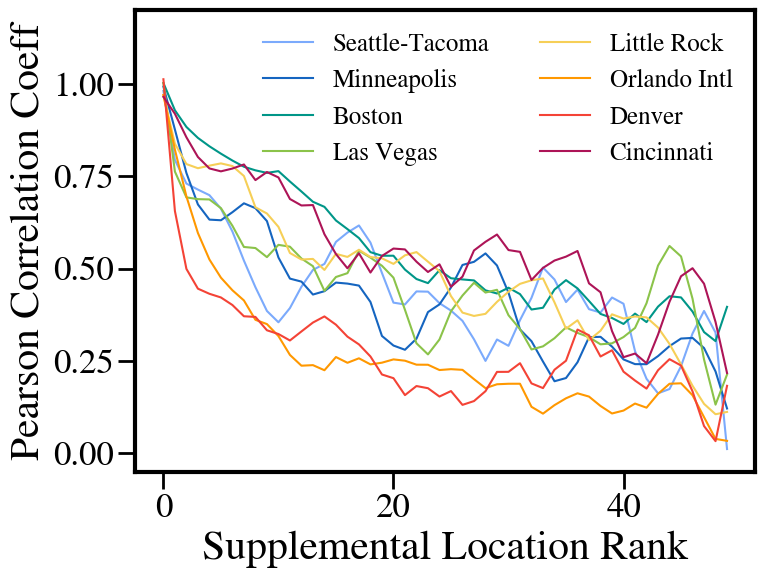

In [28]:
colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 'gray',
'#ad1457ff']

for loc in range(len(station_points['name'])):
    if loc == 7:
        #skip duplicate Denver station
        continue
    sg = scipy.signal.savgol_filter(p_coeff[loc], window_length=15, polyorder=5)
    plt.plot(np.arange(len(sg)), sg, color=colors[loc],label=st_names[loc].title())

#sg = scipy.signal.savgol_filter(rand_coeff, window_length=20, polyorder=10)
#plt.plot(np.arange(len(sg)), sg, color='orange',label='Random Locations')#st_names[loc].title())

plt.legend(frameon=False, fontsize=18, ncol=2)
plt.ylim([-0.05, 1.2])
plt.xlabel('Supplemental Location Rank')
plt.ylabel('Pearson Correlation Coeff')
#plt.title(st_names[loc].title())

# Stats By month

In [43]:
files=[]
for month in range(1,5):
    files.append(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/limit_water_v4/blend.supplemental_locations_{month}.co.2p5.nc')

In [45]:
from dask.distributed import Client

client = Client(n_workers=24)

ds = xr.open_mfdataset(files, combine="nested", engine='h5netcdf',concat_dim=[pd.Index(np.arange(4), name="month")], parallel=True)

/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45415 instead
  warnings.warn(


In [46]:
ds

<xarray.Dataset>
Dimensions:        (ya: 1597, xa: 2345, month: 4, xsupp: 50)
Coordinates:
    latitude       (ya, xa) float32 dask.array<chunksize=(1597, 2345), meta=np.ndarray>
    longitude      (ya, xa) float32 dask.array<chunksize=(1597, 2345), meta=np.ndarray>
  * month          (month) int64 0 1 2 3
Dimensions without coordinates: ya, xa, xsupp
Data variables:
    xlocations     (month, xsupp, ya, xa) float64 dask.array<chunksize=(1, 50, 1597, 2345), meta=np.ndarray>
    ylocations     (month, xsupp, ya, xa) float64 dask.array<chunksize=(1, 50, 1597, 2345), meta=np.ndarray>
    nsupplemental  (month, ya, xa) float32 dask.array<chunksize=(1, 1597, 2345), meta=np.ndarray>
    differences    (month, xsupp, ya, xa) float32 dask.array<chunksize=(1, 1, 1597, 2345), meta=np.ndarray>
Attributes:
    domain:   co
    month:    1

In [49]:
#lat,lon indices for SL locations
xlocs = ds.xlocations.data.compute()
ylocs = ds.ylocations.data.compute()

#penalty func values
diffs = ds.differences.data.compute()

In [48]:
nx = np.shape(xlocs)[3]
ny = np.shape(xlocs)[2]

In [20]:
#gather precip distributions for each month
p_coeffs = np.zeros((12, len(station_points['name']), 50)) #month, station, SL (50 incl the origin point itself)

#collect precip statistics for each target location
precip_mean = np.zeros((12, len(station_points['name'])))
precip_max = np.zeros((12, len(station_points['name'])))
precip_spread = np.zeros((12, len(station_points['name'])))

for month in range(1,13):
    precip_files=[]
    print(f'Gathering Files for {t1.strftime("%B")}')
    for year in range(2002, 2024):
        t1 = datetime.datetime(year=year, month=month, day=1)
        if month in [1,3,5,7,8,10]:
            t2 = datetime.datetime(year=year, month=month, day=31)
        elif month in [4,6,9,11,12]:
            t2 = datetime.datetime(year=year, month=month, day=30)
        else:
            t2 = datetime.datetime(year=year, month=month, day=28)
        first_doy = t1.strftime('%j')
        last_doy = t2.strftime('%j')
        for day in range(int(first_doy), int(last_doy)+1):
            precip_files.append(sorted(glob(f'/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/{year}/{year}{day:03d}.*.nc')))

    print('Processing files, making daily sums')
    n_processes = 24
    start = datetime.datetime.now()
    with multiprocessing.Pool(n_processes) as P:
        out = P.starmap(open_and_sum, zip(precip_files, np.repeat(ny, len(precip_files)), np.repeat(nx, len(precip_files))))
    out = np.asarray(out)
    end=datetime.datetime.now()
    print(f'    Finished in {(end-start).total_seconds()}s')
    P.close()

    print(f'Calculating Pearson Coefficient')
    conus_gp = get_nearest_grid(station_points['lat'], station_lons)
    for loc in range(len(station_points['name'])):
        #origin point
        gp_data = np.ravel(out[:,conus_gp[0][loc], conus_gp[1][loc]])

        precip_mean[month-1, loc] = np.mean(gp_data)
        precip_max[month-1, loc] = np.max(gp_data)
        precip_spread[month-1, loc] = np.std(gp_data)
        
        for sl in range(50):
            x_thisloc = xlocs[month-1, sl,conus_gp[0][loc], conus_gp[1][loc]]-1
            y_thisloc = ylocs[month-1, sl,conus_gp[0][loc], conus_gp[1][loc]]-1
            sl_data = np.ravel(out[:, int(y_thisloc), int(x_thisloc)])
            p_coeffs[month-1,loc, sl] = np.corrcoef(gp_data, sl_data)[0][1]
    print('-------------------------------------------------\n\n')
        

Gathering Files
Processing files, making daily sums
    Using 24 CPUs
    Finished in 51.247876s
Calculating Pearson Coefficient for January
-------------------------------------------------


Gathering Files
Processing files, making daily sums
    Using 24 CPUs
    Finished in 50.091962s
Calculating Pearson Coefficient for February
-------------------------------------------------


Gathering Files
Processing files, making daily sums
    Using 24 CPUs
    Finished in 60.981215s
Calculating Pearson Coefficient for March
-------------------------------------------------


Gathering Files
Processing files, making daily sums
    Using 24 CPUs
    Finished in 46.580922s
Calculating Pearson Coefficient for April
-------------------------------------------------


Gathering Files
Processing files, making daily sums
    Using 24 CPUs
    Finished in 52.662342s
Calculating Pearson Coefficient for May
-------------------------------------------------


Gathering Files
Processing files, making d

In [21]:
pmeans_no_first = np.mean(p_coeffs[:,:,1:], axis=2)

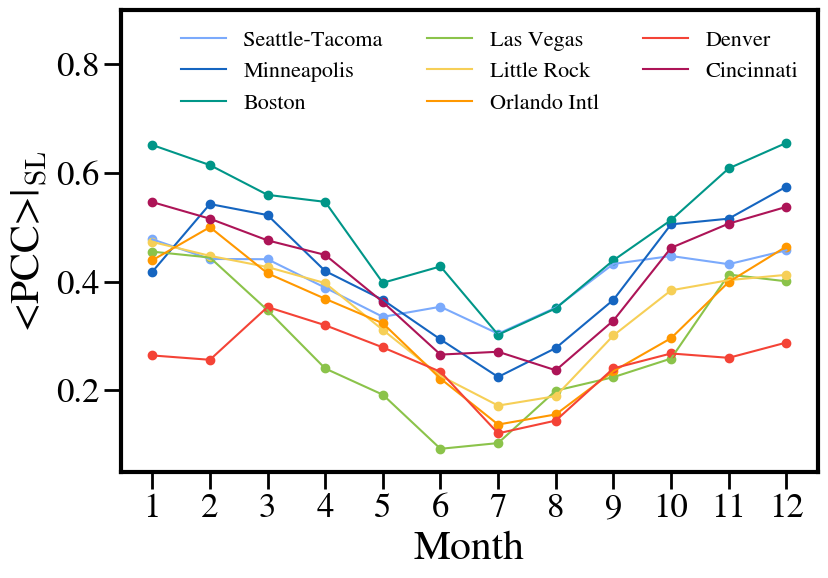

In [23]:
colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 'gray',
'#ad1457ff']

fig = plt.figure(figsize=(9,6))


for i in range(len(st_names)):
    if i == 7:
        continue
    plt.plot(np.arange(1,13), pmeans_no_first[:,i], label=st_names[i].title(), color=colors[i])
    plt.scatter(np.arange(1,13), pmeans_no_first[:,i], color=colors[i])

plt.ylabel('<PCC>|$_\mathrm{SL}$')
plt.xlabel('Month')
plt.xticks(np.arange(1,13))

plt.ylim([0.05,0.9])
plt.legend(frameon=False, fontsize=16,ncol=3)

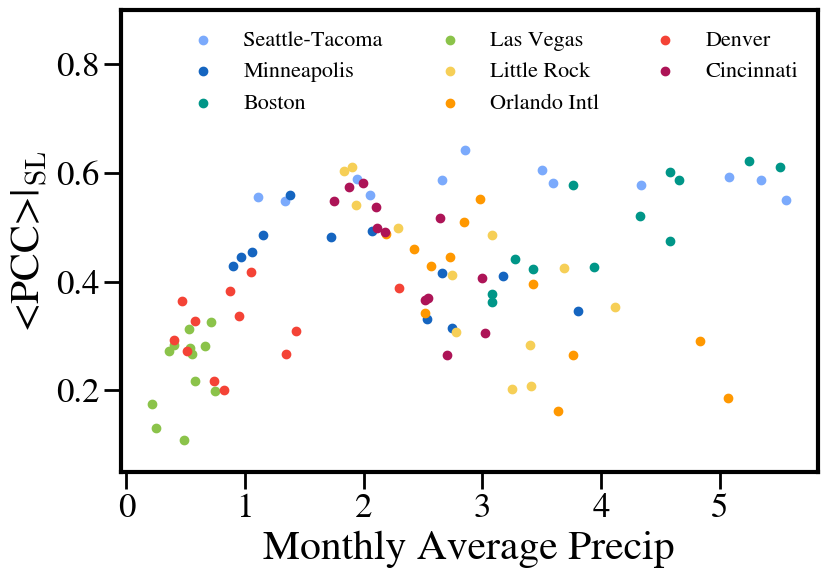

In [173]:
colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 'gray',
'#ad1457ff']

fig = plt.figure(figsize=(9,6))


for i in range(len(names)):
    if i == 7:
        continue
    #plt.plot(precip_mean[:,i], pmeans_no_first[:,i], label=names[i].title(), color=colors[i])
    plt.scatter(precip_mean[:,i], pmeans_no_first[:,i], color=colors[i],label=names[i].title())

plt.ylabel('<PCC>|$_\mathrm{SL}$')
plt.xlabel('Monthly Average Precip')
#plt.xticks(np.arange(1,13))

plt.ylim([0.05,0.9])
plt.legend(frameon=False, fontsize=16,ncol=3)

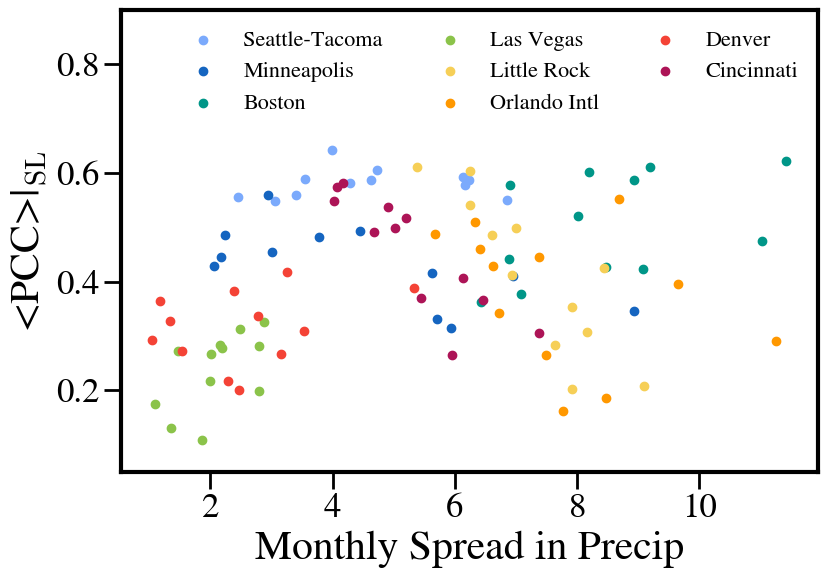

In [174]:
colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 'gray',
'#ad1457ff']

fig = plt.figure(figsize=(9,6))


for i in range(len(names)):
    if i == 7:
        continue
    #plt.plot(precip_mean[:,i], pmeans_no_first[:,i], label=names[i].title(), color=colors[i])
    plt.scatter(precip_spread[:,i], pmeans_no_first[:,i], color=colors[i],label=names[i].title())

plt.ylabel('<PCC>|$_\mathrm{SL}$')
plt.xlabel('Monthly Spread in Precip')
#plt.xticks(np.arange(1,13))

plt.ylim([0.05,0.9])
plt.legend(frameon=False, fontsize=16,ncol=3)

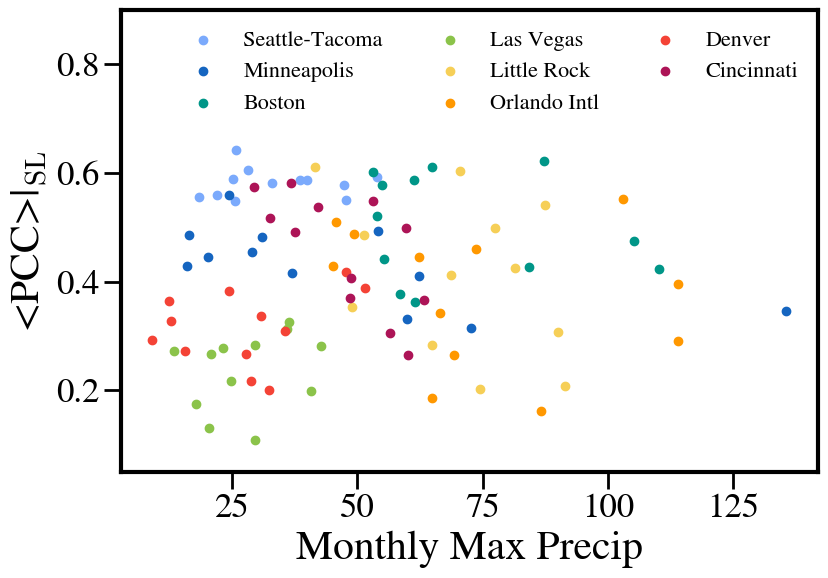

In [175]:
colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 'gray',
'#ad1457ff']

fig = plt.figure(figsize=(9,6))


for i in range(len(names)):
    if i == 7:
        continue
    #plt.plot(precip_mean[:,i], pmeans_no_first[:,i], label=names[i].title(), color=colors[i])
    plt.scatter(precip_max[:,i], pmeans_no_first[:,i], color=colors[i],label=names[i].title())

plt.ylabel('<PCC>|$_\mathrm{SL}$')
plt.xlabel('Monthly Max Precip')
#plt.xticks(np.arange(1,13))

plt.ylim([0.05,0.9])
plt.legend(frameon=False, fontsize=16,ncol=3)

In [24]:
pspreads = np.std(p_coeffs[:,:,1:], axis=2)

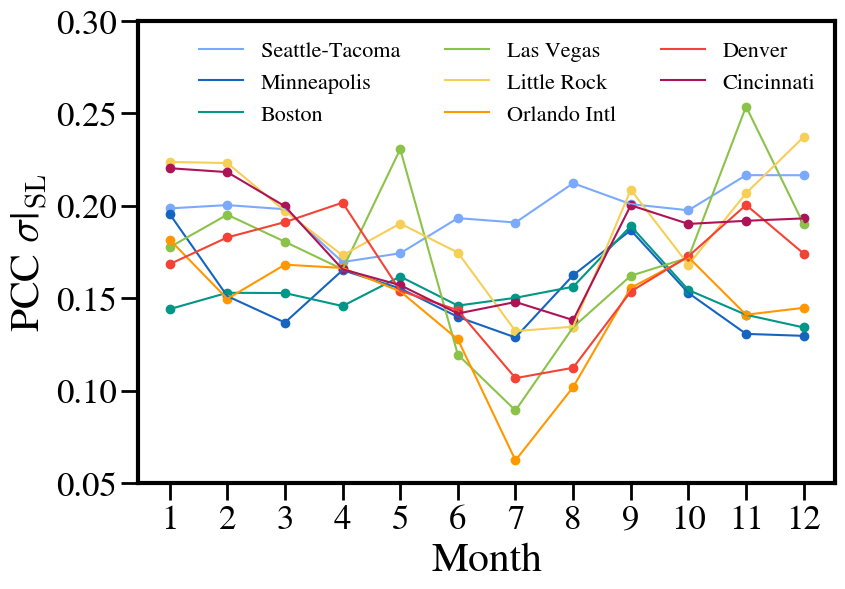

In [26]:
colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 'gray',
'#ad1457ff']

fig = plt.figure(figsize=(9,6))


for i in range(len(st_names)):
    if i == 7:
        continue
    plt.plot(np.arange(1,13), pspreads[:,i], label=st_names[i].title(), color=colors[i])
    plt.scatter(np.arange(1,13), pspreads[:,i], color=colors[i])

plt.ylabel('PCC $\sigma$|$_\mathrm{SL}$')
plt.xlabel('Month')
plt.xticks(np.arange(1,13))

plt.ylim([0.05,0.3])
plt.legend(frameon=False, fontsize=16,ncol=3)

In [82]:
diffs_at_locs = diffs[:,1:,conus_gp[0], conus_gp[1]]

mean_diffs = np.mean(diffs_at_locs, axis=1)
std_diffs = np.std(diffs_at_locs, axis=1)

Text(0.5, 1.0, 'March')

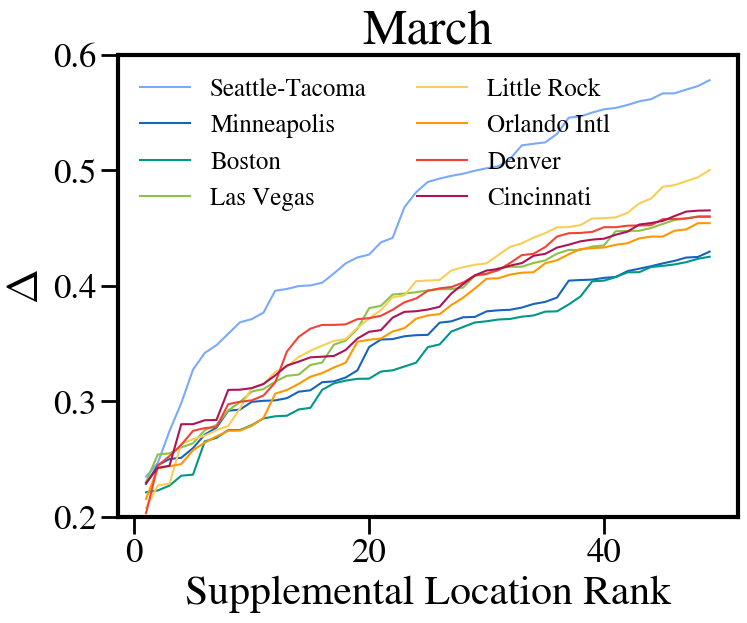

In [90]:
month=3

colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 'gray',
'#ad1457ff']

t1 = datetime.datetime(year=2023, month=month, day=1)
for i in range(len(st_names)):
    if i == 7:
        continue
    plt.plot(np.arange(1,50), diffs_at_locs[month-1, :, i], color=colors[i],label=st_names[i].title())

plt.ylabel(f'$\Delta$')
plt.xlabel('Supplemental Location Rank')

plt.ylim([0.2,0.6])
plt.legend(frameon=False, fontsize=18,ncol=2)

plt.title(t1.strftime("%B"))

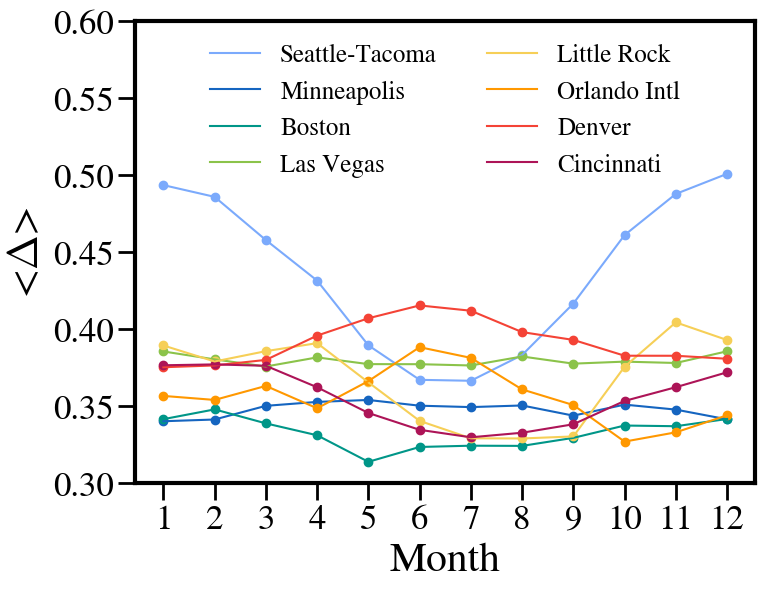

In [96]:
colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 'gray',
'#ad1457ff']

for i in range(len(st_names)):
    if i == 7:
        continue
    plt.plot(np.arange(1,13), mean_diffs[:,i],color=colors[i],label=st_names[i].title())
    #plt.fill_between(np.arange(1,13), y1=y1[:,i], y2=y2[:,i], alpha=0.5)
    plt.scatter(np.arange(1,13), mean_diffs[:,i],color=colors[i])

plt.ylabel('<$\Delta$>')
plt.xlabel('Month')
plt.xticks(np.arange(1,13))

plt.ylim([0.30,0.6])
plt.legend(frameon=False, fontsize=18,ncol=2)

# Limiting use of water SLs for land points

In [76]:
month = 4

ds = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/limit_water_v3/blend.supplemental_locations_{month}.co.2p5.nc',
             mode="r")

In [77]:
ds

<xarray.Dataset>
Dimensions:        (ya: 1597, xa: 2345, xsupp: 50)
Coordinates:
    latitude       (ya, xa) float32 ...
    longitude      (ya, xa) float32 ...
Dimensions without coordinates: ya, xa, xsupp
Data variables:
    xlocations     (xsupp, ya, xa) float64 ...
    ylocations     (xsupp, ya, xa) float64 ...
    nsupplemental  (ya, xa) float32 ...
    differences    (xsupp, ya, xa) float32 ...
Attributes:
    domain:   co
    month:    4

In [78]:
#lat,lon indices for SL locations
xlocs = ds.xlocations.data
ylocs = ds.ylocations.data

#unpack lats and lons to index over
lat_arr = ds.latitude.data
lon_arr = ds.longitude.data

In [4]:
#load MSWEP precip data just to plot over

dt = datetime.datetime(year=2023, month=month, day=16)
this_doy = int(dt.strftime('%j'))

precip = xr.open_mfdataset(sorted(glob(f'/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2023/2023{this_doy:03d}.*.nc')), 
                           combine="nested", engine='h5netcdf',concat_dim='time')

In [5]:
precip_totals = precip.precipitation.sum(dim='time').data.compute()
precip_totals = np.where(precip_totals <= 0.254, precip_totals*0., precip_totals)

Text(0.5, 1.0, 'Supplemental Locations April 2023')

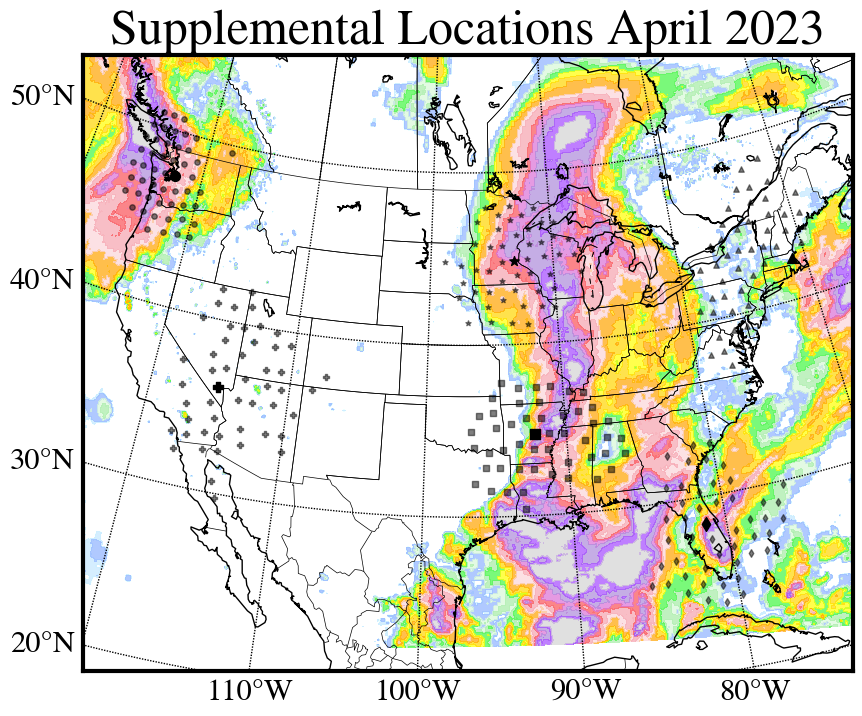

In [83]:
fig, axes = plt.subplots(1,1, figsize=(16,8))

clevs_precip = np.array([0.0,0.1,0.3,0.5,0.7,1.0,1.5,2.0,3.0,5.0,7.0,10.0,12.0,15.0,20.,25.])

colorst = ['White','#E4FFFF','#C4E8FF','#8FB3FF','#D8F9D8',\
    '#A6ECA6','#42F742','Yellow','Gold','Orange','#FCD5D9','#F6A3AE',\
        '#FA5257','Orchid','#AD8ADB','#A449FF','LightGray'] 

lats, lons = precip.latitude.data, precip.longitude.data
m = Basemap(projection='lcc',lon_0=-97,lat_0=39,width=5e6,height=4e6, resolution='l')
xx, yy = m(lons,lats) #note to self, x=lons y=lats

cs = m.contourf(xx,yy,precip_totals,extend='both',ax=axes,levels= clevs_precip,cmap=None, alpha=0.7,colors=colorst)
#cbar=plt.colorbar(cs,orientation='horizontal')
#cbar.set_label(f'Precip Totals {dt.strftime("%Y-%m-%d")} [mm]')


#supp locations
markers=['o', '*', '^', 'P', 's', 'd']
for loc in range(len(station_lats)):
    #plot orgin points
    x, y = m(station_lons[loc], station_lats[loc])  # transform coordinates
    plt.scatter(x, y, s=50, marker=markers[loc], color='black')


    #plot SLs
    x_thisloc = xlocs[:,lat_idx[loc], lon_idx[loc]]
    y_thisloc = ylocs[:,lat_idx[loc], lon_idx[loc]]

    x_thisloc = [-1 if i==len(lon_arr) else int(i) for i in x_thisloc]
    y_thisloc = [-1 if i==len(lat_arr) else int(i) for i in y_thisloc]
    
    sl_lons = lon_arr[x_thisloc]
    sl_lats = lat_arr[y_thisloc]
    x, y = m(sl_lons, sl_lats)  # transform coordinates
    plt.scatter(x, y, s=15, marker=markers[loc], color='black', alpha=0.5)


m.drawcoastlines(ax=axes)
m.drawcountries(ax=axes)
m.drawstates(ax=axes)
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes)
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes)

plt.title(f'Supplemental Locations {dt.strftime("%B")} 2023')

## Correlation

In [65]:
month = 4

ds_default = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/test_default_params/blend.supplemental_locations_{month}.co.2p5.nc',
             mode="r")

ds_limit = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/limit_water_v3/blend.supplemental_locations_{month}.co.2p5.nc',
             mode="r")

In [66]:
#lat,lon indices for SL locations
xlocs_d = ds_default.xlocations.data
ylocs_d = ds_default.ylocations.data

xlocs_l = ds_limit.xlocations.data
ylocs_l = ds_limit.ylocations.data

In [67]:

precip_files=[]
for year in range(2002, 2024):
    t1 = datetime.datetime(year=year, month=month, day=1)
    t2 = datetime.datetime(year=year, month=month, day=30)
    first_doy = t1.strftime('%j')
    last_doy = t2.strftime('%j')
    for day in range(int(first_doy), int(last_doy)+1):
        precip_files.append(sorted(glob(f'/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/{year}/{year}{day:03d}.*.nc')))


In [68]:
nx = np.shape(ds_default.latitude)[1]
ny = np.shape(ds_default.latitude)[0]

n_processes = 24

print('Processing files, making daily sums')
start = datetime.datetime.now()
print(f'    Using {n_processes} CPUs')
with multiprocessing.Pool(n_processes) as P:
    out = P.starmap(open_and_sum, zip(precip_files, np.repeat(ny, len(precip_files)), np.repeat(nx, len(precip_files))))
out = np.asarray(out)
end=datetime.datetime.now()
print(f'    Finished in {(end-start).total_seconds()}s')
P.close()

Processing files, making daily sums
    Using 24 CPUs
    Finished in 56.134458s


In [71]:
p_coeffs = np.zeros((2, len(station_points['name']), 50)) #Dataset, station, SL
for loc in range(len(station_points['name'])):
    #origin point
    gp_data = np.ravel(out[:,conus_gp[0][loc], conus_gp[1][loc]])

    #default params SLs
    dataset=0
    for sl in range(50):
        x_thisloc = xlocs_d[sl,conus_gp[0][loc], conus_gp[1][loc]]-1
        y_thisloc = ylocs_d[sl,conus_gp[0][loc], conus_gp[1][loc]]-1
        sl_data = np.ravel(out[:, int(y_thisloc), int(x_thisloc)])
        p_coeffs[dataset, loc, sl] = np.corrcoef(gp_data, sl_data)[0][1]

    #limited water gps SLs
    dataset=1
    for sl in range(50):
        x_thisloc = xlocs_l[sl,conus_gp[0][loc], conus_gp[1][loc]]-1
        y_thisloc = ylocs_l[sl,conus_gp[0][loc], conus_gp[1][loc]]-1
        sl_data = np.ravel(out[:, int(y_thisloc), int(x_thisloc)])
        p_coeffs[dataset, loc, sl] = np.corrcoef(gp_data, sl_data)[0][1]
            
    

Text(0.5, 1.0, 'Limited Use of Water Points')

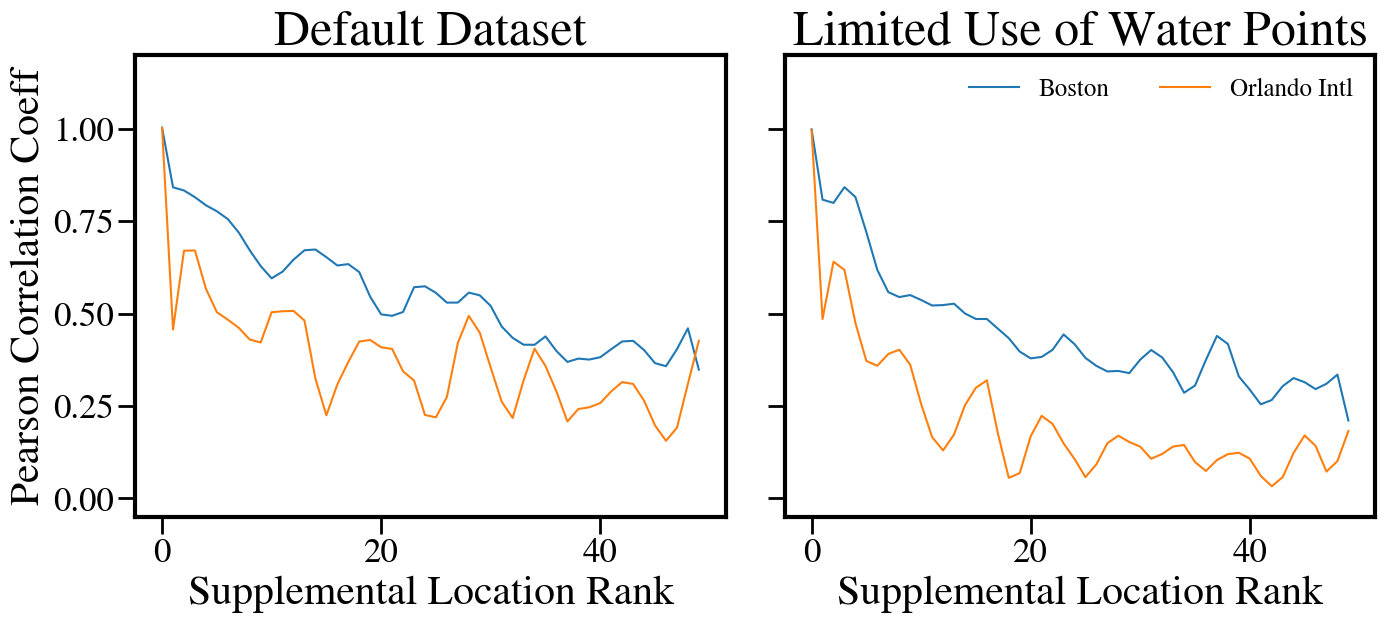

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16, 6))

for loc in [2,5]:#range(len(station_points['name'])):
    sg = scipy.signal.savgol_filter(p_coeffs[0][loc], window_length=20, polyorder=10)
    ax1.plot(np.arange(len(sg)), sg, label=station_points['name'][loc].title())

    sg = scipy.signal.savgol_filter(p_coeffs[1][loc], window_length=20, polyorder=10)
    ax2.plot(np.arange(len(sg)), sg, label=station_points['name'][loc].title())

plt.subplots_adjust(wspace=0.1)
ax2.legend(frameon=False, fontsize=18, ncol=2)
ax1.set_ylim([-0.05, 1.2])
ax1.set_xlabel('Supplemental Location Rank')
ax2.set_xlabel('Supplemental Location Rank')
ax1.set_ylabel('Pearson Correlation Coeff')
ax1.set_title('Default Dataset')
ax2.set_title('Limited Use of Water Points')

In [73]:
pmeans = np.mean(p_coeffs, axis=2)

In [74]:
for loc in [2, 5]:
    print('       Default   Limited Water')
    print(f'{station_points["call"][loc].title()}: {pmeans[:,loc]}')

       Default   Limited Water
Kbos: [0.55602951 0.45199159]
       Default   Limited Water
Kmco: [0.38128497 0.21543385]


## land proximity file??

In [73]:
prox_file = '/scratch1/NCEPDEV/mdl/Eric.Engle/gitrepos/blend/fix//precip/blend.precip_const.co.2p5.nc'

In [74]:
proximity_ds = xr.open_dataset(prox_file)

In [75]:
proximity_ds

<xarray.Dataset>
Dimensions:               (ya: 1597, xa: 2345, ngds_grib2: 200,
                           smooth_radius: 5, ngds_tdlpack: 12)
Coordinates:
    latitude              (ya, xa) float32 ...
    longitude             (ya, xa) float32 ...
  * smooth_radius         (smooth_radius) int32 1 5 10 20 40
  * xa                    (xa) float32 0.0 2.54e+03 ... 5.951e+06 5.953e+06
  * ya                    (ya) float32 0.0 2.54e+03 ... 4.051e+06 4.053e+06
Dimensions without coordinates: ngds_grib2, ngds_tdlpack
Data variables: (12/15)
    analysis_source_mask  (ya, xa) float32 ...
    conuslandmask         (ya, xa) float32 ...
    greatlakes_mask       (ya, xa) float32 ...
    grib2_gds             (ngds_grib2) int32 ...
    land_proximity        (ya, xa) float32 ...
    landmask              (ya, xa) float32 ...
    ...                    ...
    terrain_facets        (smooth_radius, ya, xa) float32 ...
    terrain_smoothed      (smooth_radius, ya, xa) float32 ...
    validmask             (ya, xa) float32 ...
    validmask_capa        (ya, xa) int16 ...
    validmask_ccpa        (ya, xa) int16 ...
    validmask_cmorph      (ya, xa) int16 ...
Attributes:
    title:        Masks and Terrain for Blend Precip Quantile Mapping
    Conventions:  CF-1.6
    institution:  ESRL/PSD NWS/MDL
    domain:       co

In [12]:
land_mask = proximity_ds.landmask.data

Text(0.5, 1.0, 'Supplemental Locations April 2023')

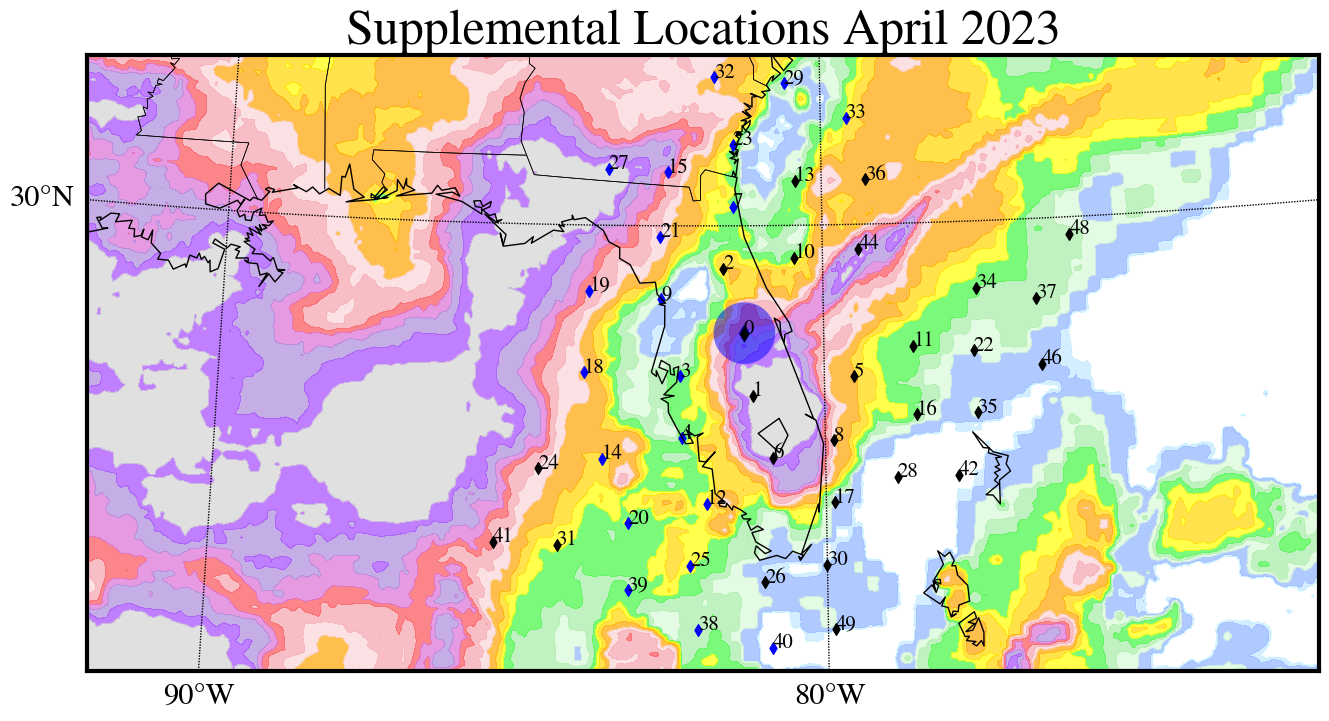

In [13]:
fig, axes = plt.subplots(1,1, figsize=(16,8))

clevs_precip = np.array([0.0,0.1,0.3,0.5,0.7,1.0,1.5,2.0,3.0,5.0,7.0,10.0,12.0,15.0,20.,25.])

colorst = ['White','#E4FFFF','#C4E8FF','#8FB3FF','#D8F9D8',\
    '#A6ECA6','#42F742','Yellow','Gold','Orange','#FCD5D9','#F6A3AE',\
        '#FA5257','Orchid','#AD8ADB','#A449FF','LightGray'] 

lats, lons = ds.latitude.data, ds.longitude.data
m = Basemap(projection='lcc',lon_0=-82,lat_0=28,width=2e6,height=1e6, resolution='l')
xx, yy = m(lons,lats) #note to self, x=lons y=lats

cs = m.contourf(xx,yy,precip_totals,extend='both',ax=axes,levels= clevs_precip,cmap=None, alpha=0.7,colors=colorst)
def radius_for_tissot(dist_km): 
    return np.rad2deg(dist_km/6367.) 

#supp locations
markers=['o', '*', '^', 'P', 's', 'd']
for loc in [5]:#range(len(station_lats)):
    #plot orgin points
    x, y = m(station_lons[loc], station_lats[loc])  # transform coordinates
    plt.scatter(x, y, s=70, marker=markers[loc], color='black')
 
    lon0, lat0 = station_lons[loc], station_lats[loc]
    m.tissot(lon0, lat0, radius_for_tissot(50), 256, facecolor='b', alpha=0.5)

    #plot SLs
    x_thisloc = xlocs[:,lat_idx[loc], lon_idx[loc]]
    y_thisloc = ylocs[:,lat_idx[loc], lon_idx[loc]]
    #bookkeeping for fortran --> python indices
    x_thisloc = [int(i)-1 for i in x_thisloc]
    y_thisloc = [int(i)-1 for i in y_thisloc]
    #index lat/lon
    sl_lons = lon_arr[x_thisloc]
    sl_lats = lat_arr[y_thisloc]
    x, y = m(sl_lons, sl_lats)  # transform coordinates
    for sl_num in range(50):
        plt.annotate(f'{sl_num}', xy=(x[sl_num], y[sl_num]), fontsize=15)
        
        if land_mask[y_thisloc[sl_num], x_thisloc[sl_num]] == 1.0:
            plt.scatter(x[sl_num], y[sl_num], s=35, marker=markers[loc], color='blue')
        else:
            plt.scatter(x[sl_num], y[sl_num], s=35, marker=markers[loc], color='black')


m.drawcoastlines(ax=axes)
m.drawcountries(ax=axes)
m.drawstates(ax=axes)
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes)
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes)

plt.title(f'Supplemental Locations {dt.strftime("%B")} 2023')